# CLIP for MNIST images and text labels 

In [12]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from collections import OrderedDict
from typing import Tuple, Union
import torch.nn.functional as F
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Load the MNIST dataset from torch

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 471112875.29it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105980484.54it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 185243783.06it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5970081.09it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



## Visualise the data

Consider the title on the top of each image as the (text) label we want to learn. 

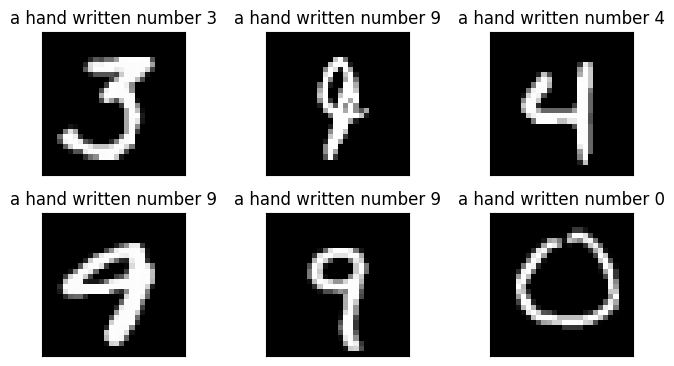

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure(figsize=(7, 4))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("a hand written number {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## Text encoder

In this simple example, we only use an MLP to extract the features from text. 


In [4]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, h_dims, out_dim, n_layers=3, context_len=5):
        super(TextEncoder, self).__init__()
        self.n_layers = n_layers
        self.token_embedding = nn.Embedding(vocab_size, emb_dim)
        self.out_dim = out_dim
        self.h_dims = h_dims
        self.layers = []
        self.in_dims = emb_dim * context_len
        for i in range(self.n_layers-1):
            self.layers.append((f'linear{i+1}', torch.nn.Linear(self.in_dims, self.h_dims)))
            self.layers.append((f'relu{i+1}', torch.nn.ReLU()))
            self.in_dims = self.h_dims

        self.model = torch.nn.Sequential(OrderedDict(self.layers))
        self.last_layer = torch.nn.Linear(self.h_dims, self.out_dim, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.token_embedding(x)
        x = torch.flatten(x, start_dim=1)
        last_layer_latent = self.model(x)
        x = self.last_layer(last_layer_latent)
        return x

## Image encoder

A CNN for the images, of course :)

In [5]:
# Creating an image encoder
class ImageEncoder(nn.Module):
	#  Determine what layers and their order in CNN object
    def __init__(self, out_features):
        super(ImageEncoder, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(512, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, out_features)

    # get the image features
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)

        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

## Connect the text encoder and image encoder in CLIP

In [6]:
class CLIP(nn.Module):
    def __init__(self, embed_dim: int, out_features: int, vocab_size: int, h_dims: int, text_encoder_layers: int):
        super().__init__()

        self.encode_image = ImageEncoder(out_features)
        self.encode_text = TextEncoder(vocab_size, embed_dim, h_dims, out_features, n_layers=text_encoder_layers)

        # self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)
        # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        return image_features, text_features

## The most important component in CLIP (in terms of the modelling aspect)

This is the contrastive learning objective in the paper: A Simple Framework for Contrastive Learning of Visual Representations, https://arxiv.org/pdf/2002.05709.pdf. 


If the data point $x_i$ and $x_j$ are positively paired and $z_i$ and $z_j$ the corresponding latent representations, the loss between these two points is defined as
$$
l(i, j) = - \log \frac{\exp (c(z_i, z_j) / \tau)}{\sum_{k \neq j}^{2N} \exp (c(z_i, z_k) / \tau)},
$$
where $c(\cdot, \cdot)$ is the cosine similarity, and $\tau$ is the tempurature parameter. Intuitively, we want to maximize the similarity between a positive pair.  

A positive pair is normally a pair of data points that come from the same source. For example, a photo of a dog and a crop out of it or the noisy version of it.  In this case, it could be the image of a digit of 8 and the text "a hand written number 8".

Point-wise comparison is usually expensive. See the matrix implementation below. 

In [59]:
def nt_xent_loss(image_features, text_features, temperature):
    out = torch.cat([image_features, text_features], dim=0)
    n_samples = len(out)

    cov = torch.mm(out, out.t().contiguous())
    similarity = torch.exp(cov / temperature)

    mask = ~torch.eye(n_samples, device=similarity.device).bool()
    neg = similarity.masked_select(mask).view(n_samples, -1).sum(dim=-1)

    # Positive similarity
    pos = torch.exp(torch.sum(image_features * text_features, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)

    loss = -torch.log(pos / neg).mean()
    return loss

## Load a tokenizer from HuggingFace

So I'm a bit too lazy to implement a tokenizer for the text input.  Loading one from HF. 

In [7]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.7 MB/s eta 0:00:00


In [8]:
from huggingface_hub import notebook_login

notebook_login()

## Training loop

In [ ]:
import torch.optim as optim
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-3b", use_auth_token=True,)
vocab_size = 250680

clip_model = CLIP(vocab_size=vocab_size, embed_dim=512, out_features=32, h_dims=128, text_encoder_layers=4).to(device)
optimizer = optim.Adam(clip_model.parameters(), lr=0.0001)

epochs = 5
freq = 500

counter = 0
temp = 2.65
for e in range(epochs):
    for i, data in enumerate(train_loader):

        image, labels = data
        # converting the integer labels to text inputs
        label_str = [f"a hand written number {x}" for x in labels]
        text_tokens = torch.tensor(tokenizer(label_str).input_ids)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        image_features, text_features = clip_model(image.to(device), text_tokens.to(device))

        # Compute the loss and its gradients
        loss = nt_xent_loss(image_features, text_features, temp)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        if counter % freq == 0 :
            print(f"training step {counter}: loss {loss}")

        counter += 1


## Check out the predictions


- select an image randomly from the test set.
- convert labels to text for all classes: ["a hand written number 0", ..., "a hand written number 9"]
- repeat the image 10 times - the same as the total number of classes
- use the trained model to get the representations of the image as well as of the text inputs of the classes
- compute the similarity between the image and all classes in the latent space
- choose the most probable class

#### I have to admit that I only trained the model for 4000 iterations, and the model only works well for the number 3, 5, and 7.
I had a few very good runs, where the predictions are great for all numbers.  However, it's not always possible to reproduce the results. 
But hey, it's a toy problem. Changing the text encoder to RNN or tranformer probably will help, as in the real CLIP model, see here: https://github.com/openai/CLIP



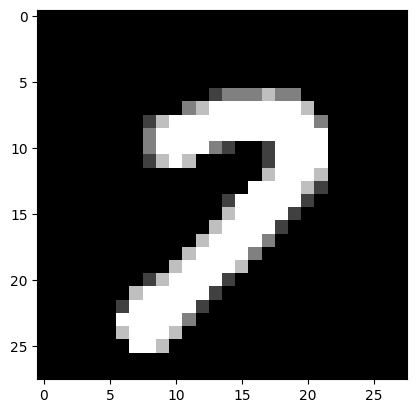

In [177]:
import random
examples = enumerate(test_loader)
batch_idx, (test_example, example_targets) = next(examples)

def select_and_process_an_image(test_example):
    n = random.randint(1, test_example.shape[0])
    data = example_data[n][0]
    label = example_targets[n]

    n_classes = 10
    image_input = torch.broadcast_to(data, (n_classes, data.shape[0], data.shape[1])).unsqueeze(dim=1)
    label_str = [f"a hand written number {x}" for x in range(n_classes)]
    text_input = torch.tensor(tokenizer(label_str).input_ids)
    return image_input, text_input

def predict(image_input, text_input):
    with torch.no_grad():
        image_features, text_features = clip_model(image_input.to(device), text_input.to(device))

    similarity = (100 * image_features @ text_features.T).softmax(dim=-1)

    values, indices = similarity[0].topk(5)

    # Print the result
    print("\nTop predictions:\n")
    for value, index in zip(values, indices):
        print(f"{label_str[index]:>16s}: {100 * value.item():.2f}%")

image_input, text_input = select_and_process_an_image(test_example)

plt.imshow(image_input[0][0], cmap='gray', interpolation='none')

In [178]:
predict(image_input, text_input)


Top predictions:

a hand written number 7: 100.00%
a hand written number 0: 0.00%
a hand written number 4: 0.00%
a hand written number 0: 0.00%
a hand written number 9: 0.00%


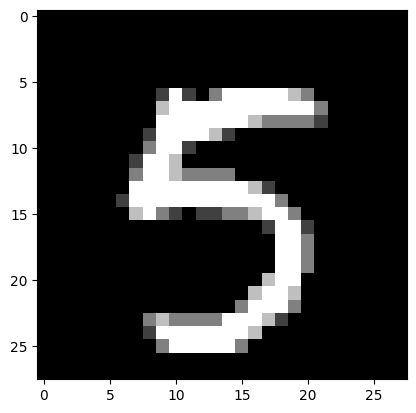

In [183]:
image_input, text_input = select_and_process_an_image(test_example)

plt.imshow(image_input[0][0], cmap='gray', interpolation='none')

In [184]:
predict(image_input, text_input)


Top predictions:

a hand written number 5: 100.00%
a hand written number 3: 0.00%
a hand written number 3: 0.00%
a hand written number 9: 0.00%
a hand written number 0: 0.00%
